###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time



### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

### Hyperparameters of machine learning algorithm.

In [4]:
ml_list={"NB":CategoricalNB(alpha=1e-09),
"DT" :DecisionTreeClassifier(criterion='gini', max_depth=26.0,
                       max_features=26,min_samples_split= 6),  
"RF":RandomForestClassifier(bootstrap= True, criterion= "gini", max_depth= 18.0, max_features= 8, min_samples_split= 9, n_estimators= 96),
"KNN":KNeighborsClassifier(algorithm= 'brute', leaf_size= 41, n_neighbors= 48, weights= 'distance'),
"GB":GradientBoostingClassifier()}

# Aggregation Algorithm notmal

In [5]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second














## Calculation of evaluations

In [6]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))

    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),4)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [7]:
def ML(loop1,loop2,output_csv,cols,step,mixed,dname):

    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        if ii in ["GB","SVM"]: #for slow algorithms.
            repetition=100
        else:
            repetition=100
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            try:df=df.replace({"Protocol": Protocol})
            except:pass
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            try:df=df.replace({"Protocol": Protocol})
            except:pass
            df = shuffle(df)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


     
   

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            ths.write (lines)


            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/repetition
        #print(class_based_results)
        class_based_results.to_csv("class_based_results.csv")
        if False:
            cm=cm//repetition
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


            
            
            
            
            
            
            


    ths.close()  

# Machine learning applications 

# Aalto Dataset

In [8]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


# DT & NB & RF &  KNN

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.53     0.03    0.56    0.0     
Aalto_1         1   2   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.43     0.03    0.46    0.0     
Aalto_1         2   3   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.45     0.03    0.48    0.0     
Aalto_1         3   4   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.48     0.03    0.51    0.0     
Aalto_1         4   5   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.41     0.03    0.44    0.0     
Aalto_1         5   6   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.4      0.03    0.43    0.0     
Aalto_1         6   7   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.4      0.03    0.43    0.0     
Aalto_1         7   8   NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.45     0.03    0.48    0.0     
Aalto_1         8   9   NB      0.62  0.63  0.58  0.63 

Aalto_1         78  79  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.41     0.03    0.44    0.0     
Aalto_1         79  80  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.41     0.03    0.44    0.0     
Aalto_1         80  81  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.42     0.03    0.46    0.0     
Aalto_1         81  82  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.42     0.03    0.45    0.0     
Aalto_1         82  83  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.42     0.03    0.45    0.0     
Aalto_1         83  84  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.42     0.03    0.45    0.0     
Aalto_1         84  85  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.41     0.03    0.44    0.0     
Aalto_1         85  86  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.41     0.03    0.44    0.0     
Aalto_1         86  87  NB      0.62  0.63  0.58  0.63  0.5587   0.58  0.39     0.03    0.42    0.0     
Aalto_1         87  88  NB      0.62  0.63  0.58  0.63 

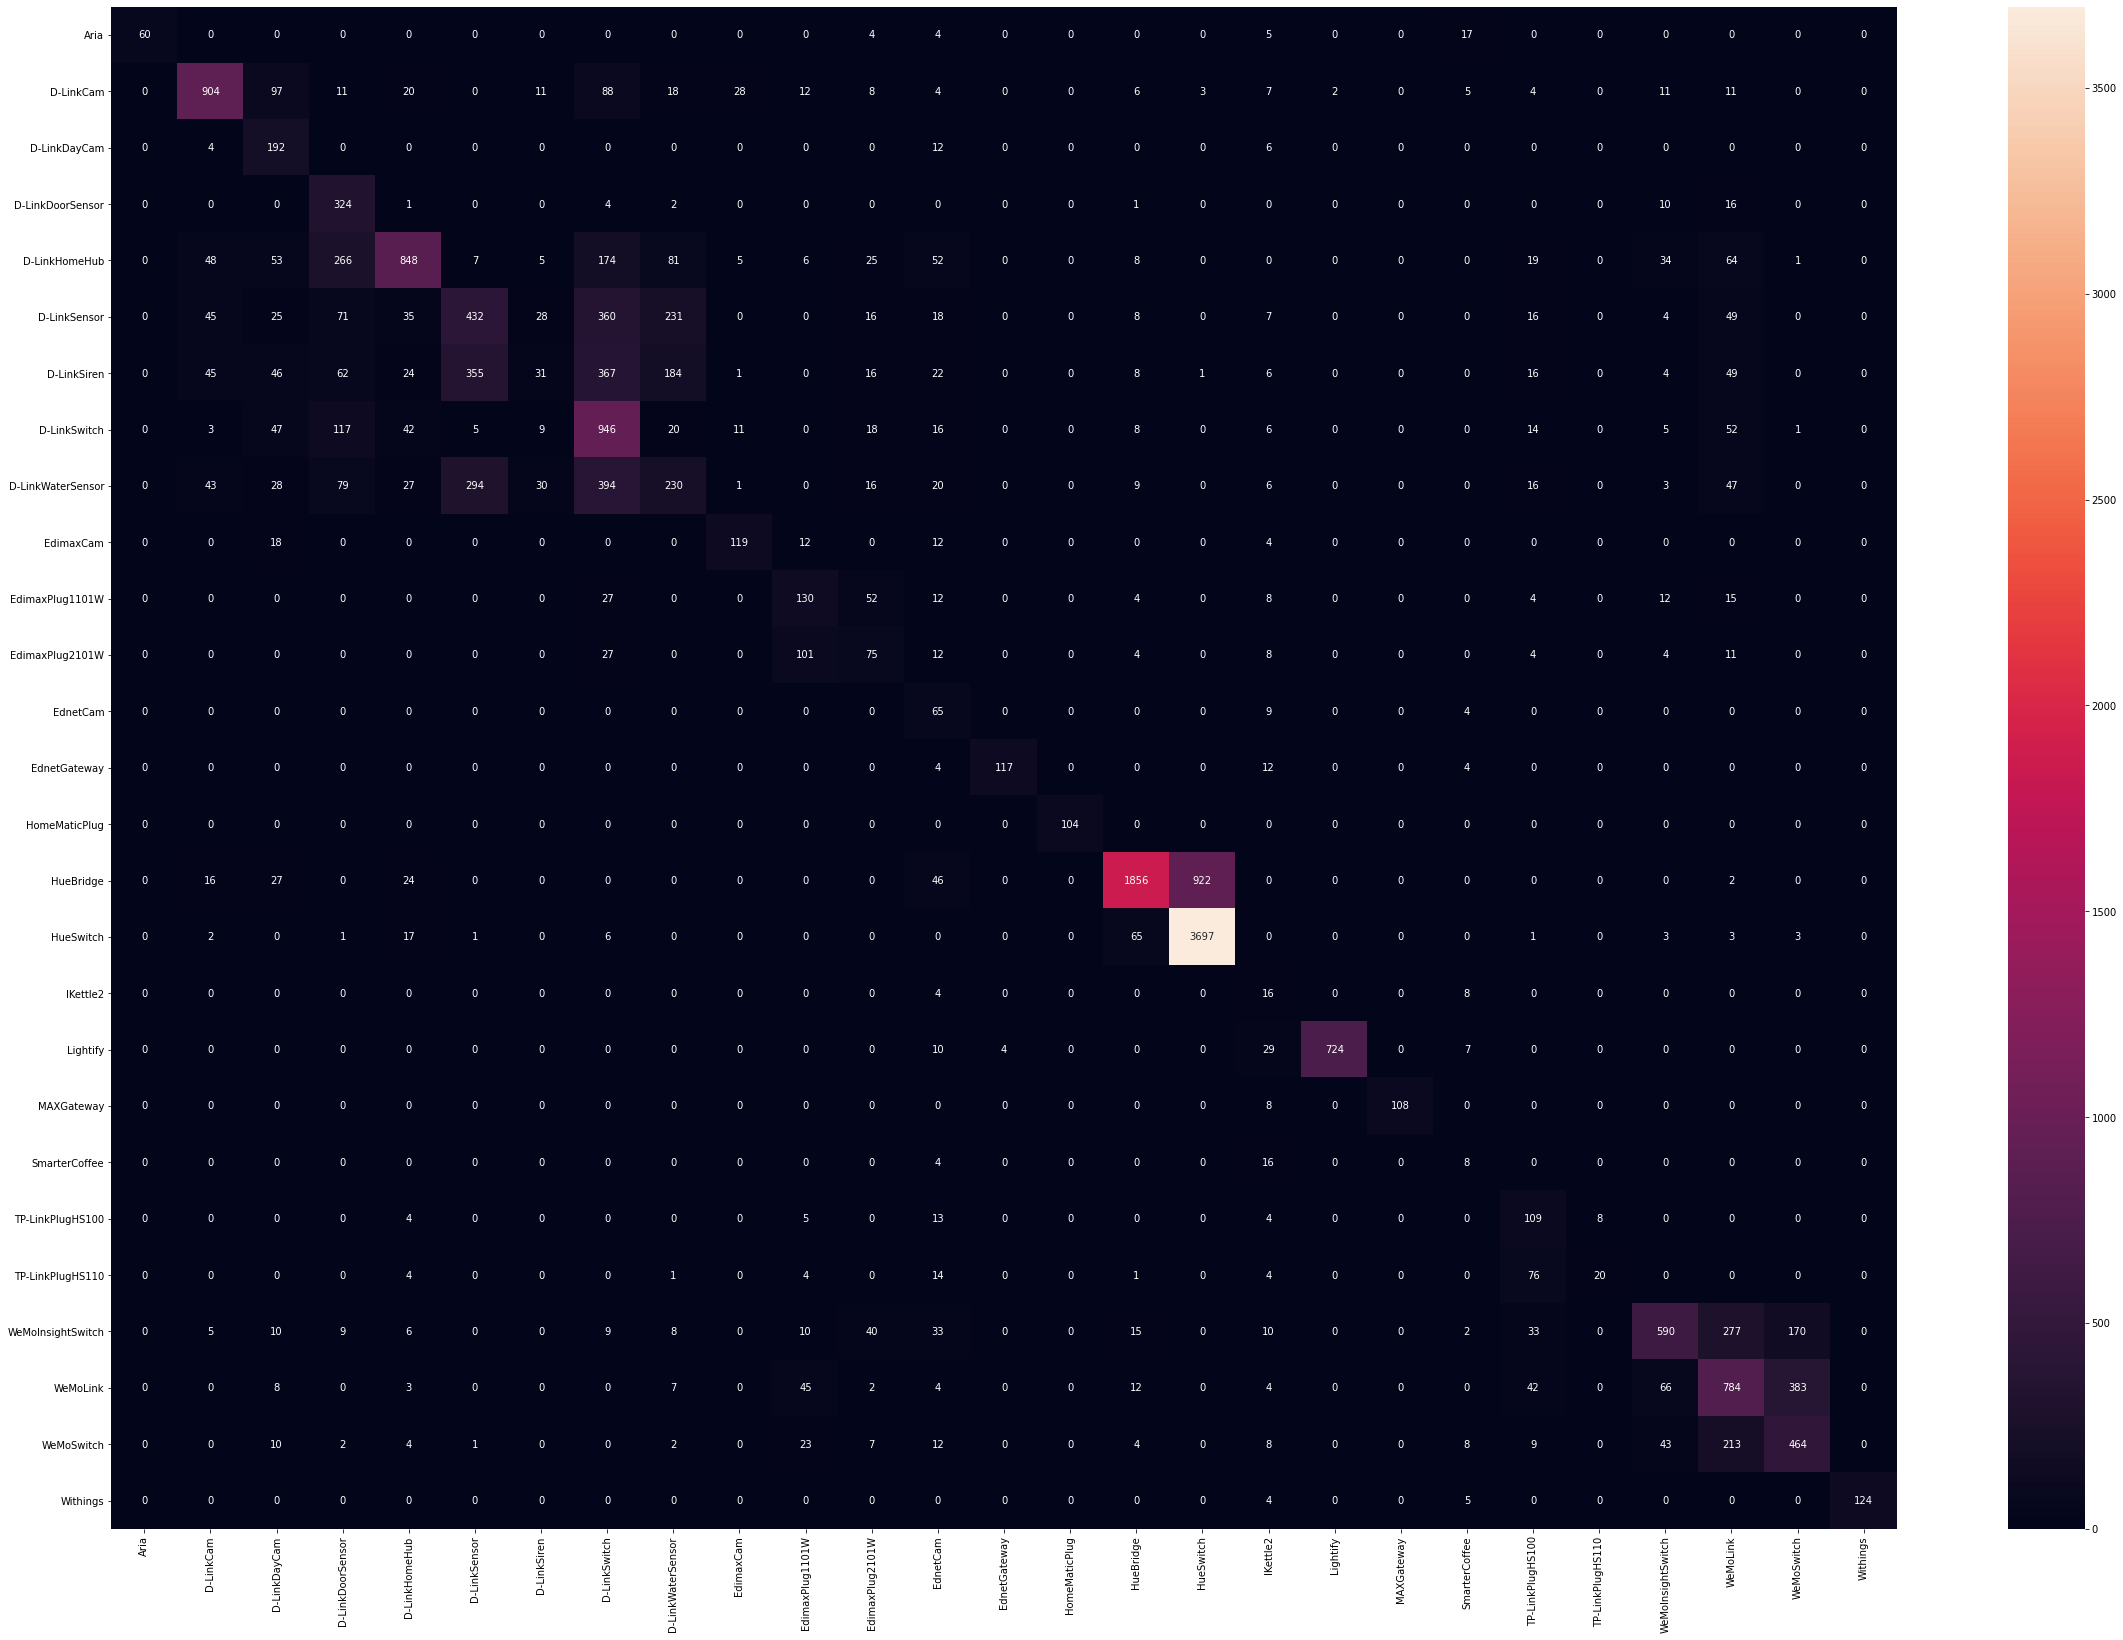





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   DT      0.7   0.71  0.78  0.71  0.7272   0.68  0.16     0.0     0.16    0.0     
Aalto_1         1   2   DT      0.71  0.71  0.78  0.71  0.7278   0.68  0.13     0.0     0.13    0.0     
Aalto_1         2   3   DT      0.71  0.71  0.78  0.71  0.7279   0.68  0.13     0.0     0.13    0.0     
Aalto_1         3   4   DT      0.7   0.71  0.78  0.71  0.7275   0.68  0.13     0.0     0.13    0.0     
Aalto_1         4   5   DT      0.71  0.71  0.78  0.71  0.7276   0.68  0.13     0.0     0.14    0.0     
Aalto_1         5   6   DT      0.71  0.71  0.78  0.71  0.7283   0.68  0.13     0.0     0.13    0.0     
Aalto_1         6   7   DT      0.71  0.71  0.77  0.71  0.7265   0.68  0.13     0.0     0.13    0.0     
Aalto_1         7   8   DT      0.71  0.71  0.78  0.71  0.7277   0.68  0.13     0.0     0.14    0.0     
Aalto_1         8   9   DT      0.71  0.71  0.78  0

Aalto_1         77  78  DT      0.71  0.71  0.78  0.71  0.7282   0.68  0.13     0.0     0.13    0.0     
Aalto_1         78  79  DT      0.71  0.71  0.77  0.71  0.7277   0.68  0.13     0.0     0.13    0.0     
Aalto_1         79  80  DT      0.7   0.71  0.78  0.71  0.7269   0.68  0.12     0.0     0.13    0.0     
Aalto_1         80  81  DT      0.71  0.71  0.77  0.71  0.7271   0.68  0.13     0.0     0.13    0.0     
Aalto_1         81  82  DT      0.7   0.7   0.77  0.7   0.7261   0.67  0.13     0.0     0.13    0.0     
Aalto_1         82  83  DT      0.71  0.71  0.78  0.71  0.7282   0.68  0.13     0.0     0.13    0.0     
Aalto_1         83  84  DT      0.71  0.71  0.77  0.71  0.7254   0.68  0.13     0.0     0.13    0.0     
Aalto_1         84  85  DT      0.71  0.7   0.77  0.7   0.7266   0.68  0.13     0.0     0.13    0.0     
Aalto_1         85  86  DT      0.71  0.71  0.77  0.71  0.7258   0.68  0.13     0.0     0.13    0.0     
Aalto_1         86  87  DT      0.7   0.71  0.77  0.71 

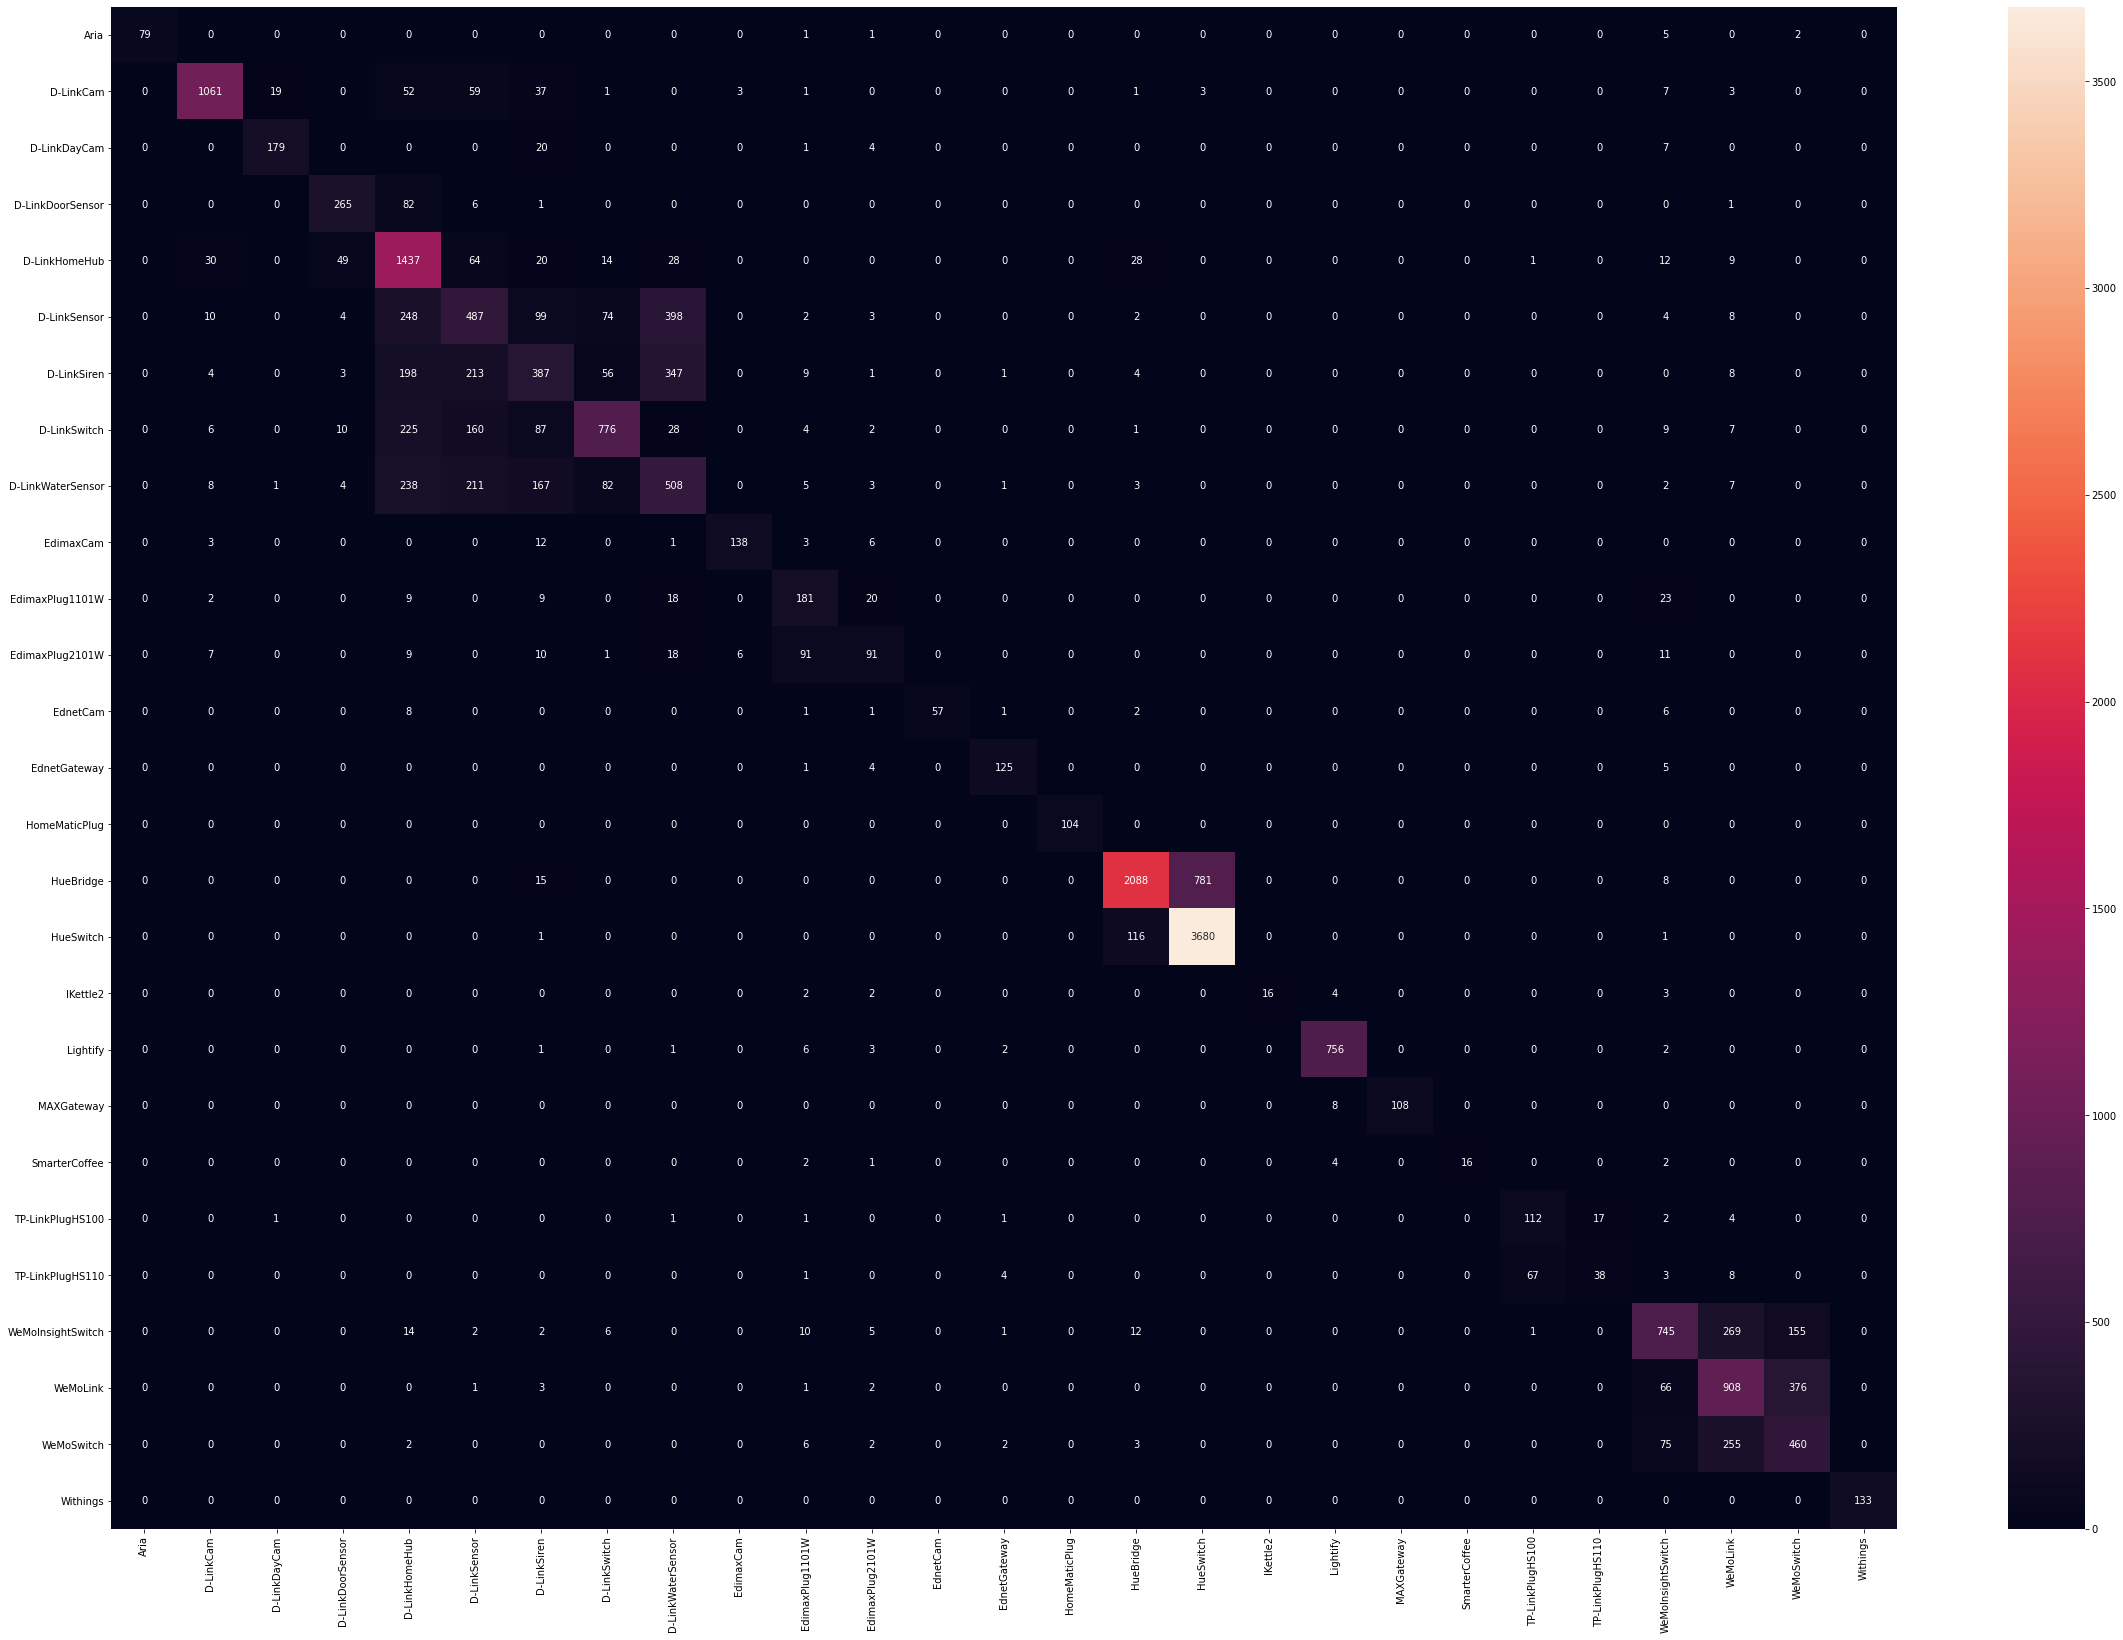





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   RF      0.71  0.71  0.77  0.71  0.7279   0.68  3.74     0.34    4.07    0.0     
Aalto_1         1   2   RF      0.71  0.71  0.77  0.71  0.7302   0.68  3.73     0.34    4.07    0.0     
Aalto_1         2   3   RF      0.71  0.71  0.77  0.71  0.728    0.68  3.72     0.33    4.05    0.0     
Aalto_1         3   4   RF      0.71  0.71  0.77  0.71  0.7275   0.68  3.79     0.34    4.13    0.0     
Aalto_1         4   5   RF      0.71  0.71  0.77  0.71  0.728    0.68  3.73     0.33    4.05    0.0     
Aalto_1         5   6   RF      0.71  0.71  0.77  0.71  0.7295   0.68  3.72     0.33    4.05    0.0     
Aalto_1         6   7   RF      0.71  0.71  0.77  0.71  0.7277   0.68  3.74     0.33    4.07    0.0     
Aalto_1         7   8   RF      0.71  0.71  0.77  0.71  0.7257   0.68  3.79     0.33    4.12    0.0     
Aalto_1         8   9   RF      0.71  0.71  0.77  0

Aalto_1         77  78  RF      0.71  0.71  0.78  0.71  0.7302   0.68  3.67     0.34    4.0     0.0     
Aalto_1         78  79  RF      0.71  0.71  0.77  0.71  0.7259   0.68  3.7      0.33    4.02    0.0     
Aalto_1         79  80  RF      0.71  0.71  0.76  0.71  0.725    0.68  3.75     0.34    4.09    0.0     
Aalto_1         80  81  RF      0.71  0.71  0.77  0.71  0.7286   0.68  3.91     0.33    4.24    0.0     
Aalto_1         81  82  RF      0.71  0.71  0.77  0.71  0.7261   0.68  3.73     0.33    4.06    0.0     
Aalto_1         82  83  RF      0.71  0.71  0.77  0.71  0.7288   0.68  3.7      0.33    4.03    0.0     
Aalto_1         83  84  RF      0.71  0.71  0.76  0.71  0.7248   0.68  3.72     0.33    4.04    0.0     
Aalto_1         84  85  RF      0.71  0.71  0.77  0.71  0.7285   0.68  3.72     0.32    4.05    0.0     
Aalto_1         85  86  RF      0.71  0.71  0.77  0.71  0.7268   0.68  3.7      0.33    4.03    0.0     
Aalto_1         86  87  RF      0.71  0.71  0.77  0.71 

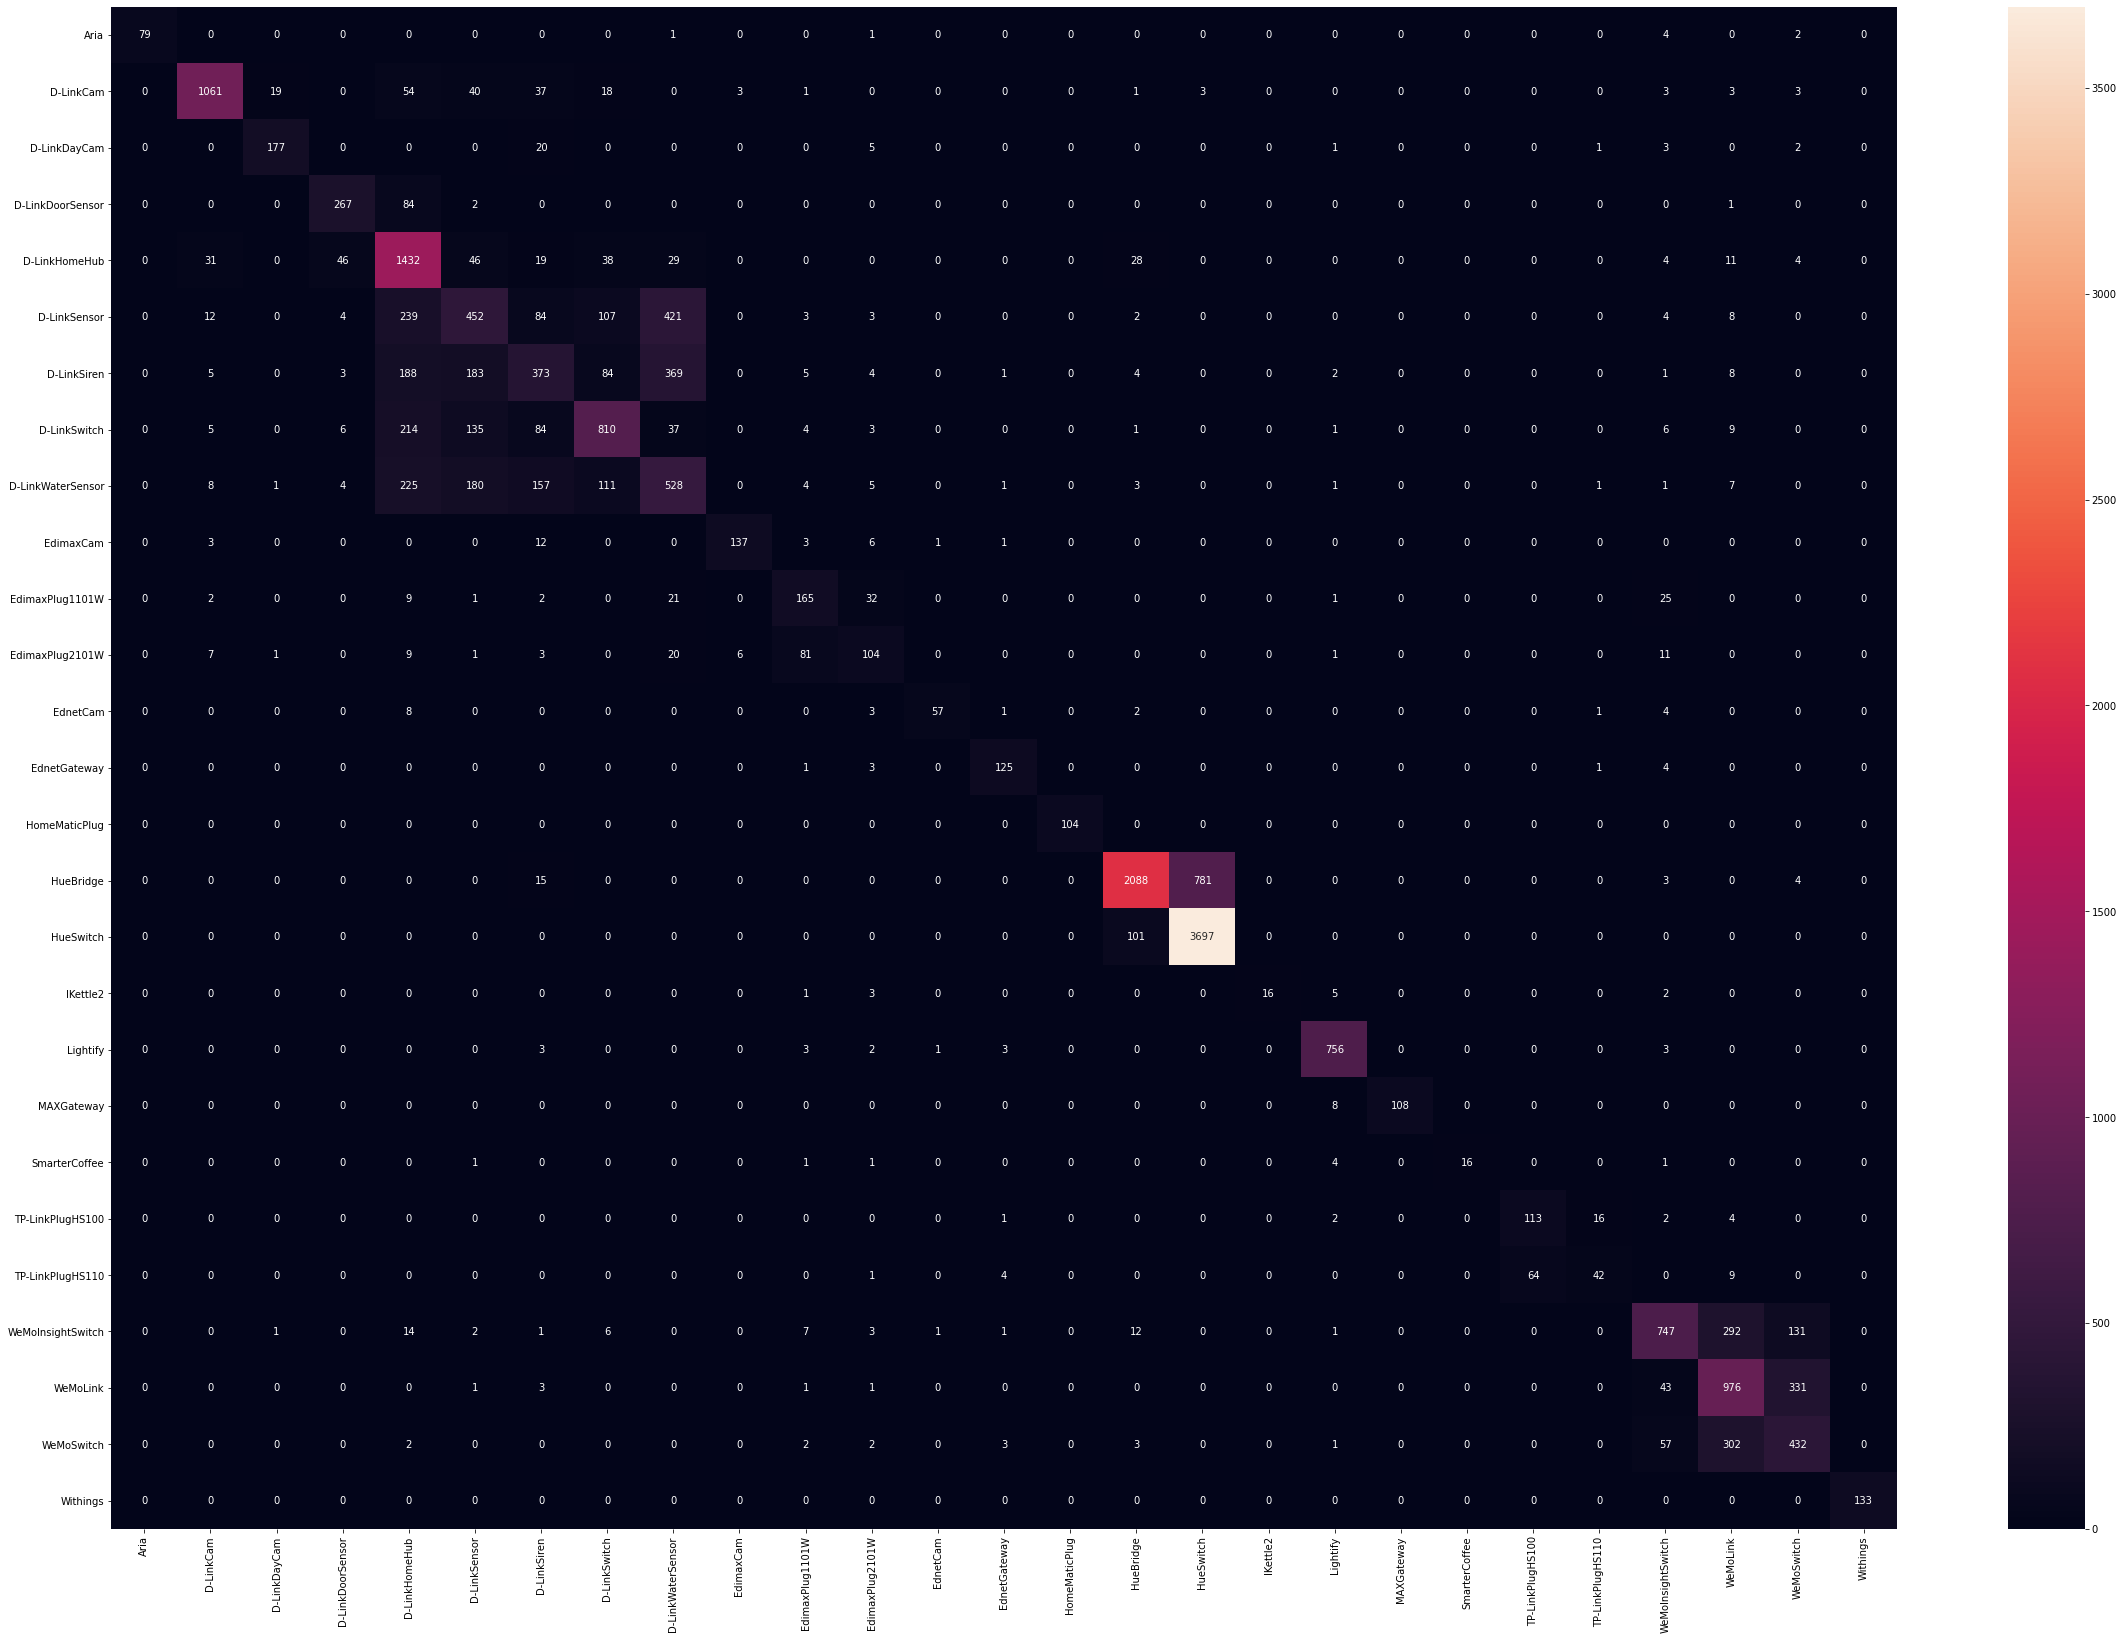





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.27   20.27   0.0     
Aalto_1         1   2   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.16   20.17   0.0     
Aalto_1         2   3   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.01     20.19   20.2    0.0     
Aalto_1         3   4   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.18   20.18   0.0     
Aalto_1         4   5   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.01     20.17   20.17   0.0     
Aalto_1         5   6   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.17   20.18   0.0     
Aalto_1         6   7   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.26   20.26   0.0     
Aalto_1         7   8   KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.18   20.18   0.0     
Aalto_1         8   9   KNN     0.71  0.71  0.75  0

Aalto_1         77  78  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.2    20.2    0.0     
Aalto_1         78  79  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.26   20.27   0.0     
Aalto_1         79  80  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.19   20.2    0.0     
Aalto_1         80  81  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.2    20.2    0.0     
Aalto_1         81  82  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.24   20.24   0.0     
Aalto_1         82  83  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.01     20.24   20.25   0.0     
Aalto_1         83  84  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.27   20.28   0.0     
Aalto_1         84  85  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.24   20.25   0.0     
Aalto_1         85  86  KNN     0.71  0.71  0.75  0.71  0.718    0.68  0.0      20.22   20.23   0.0     
Aalto_1         86  87  KNN     0.71  0.71  0.75  0.71 

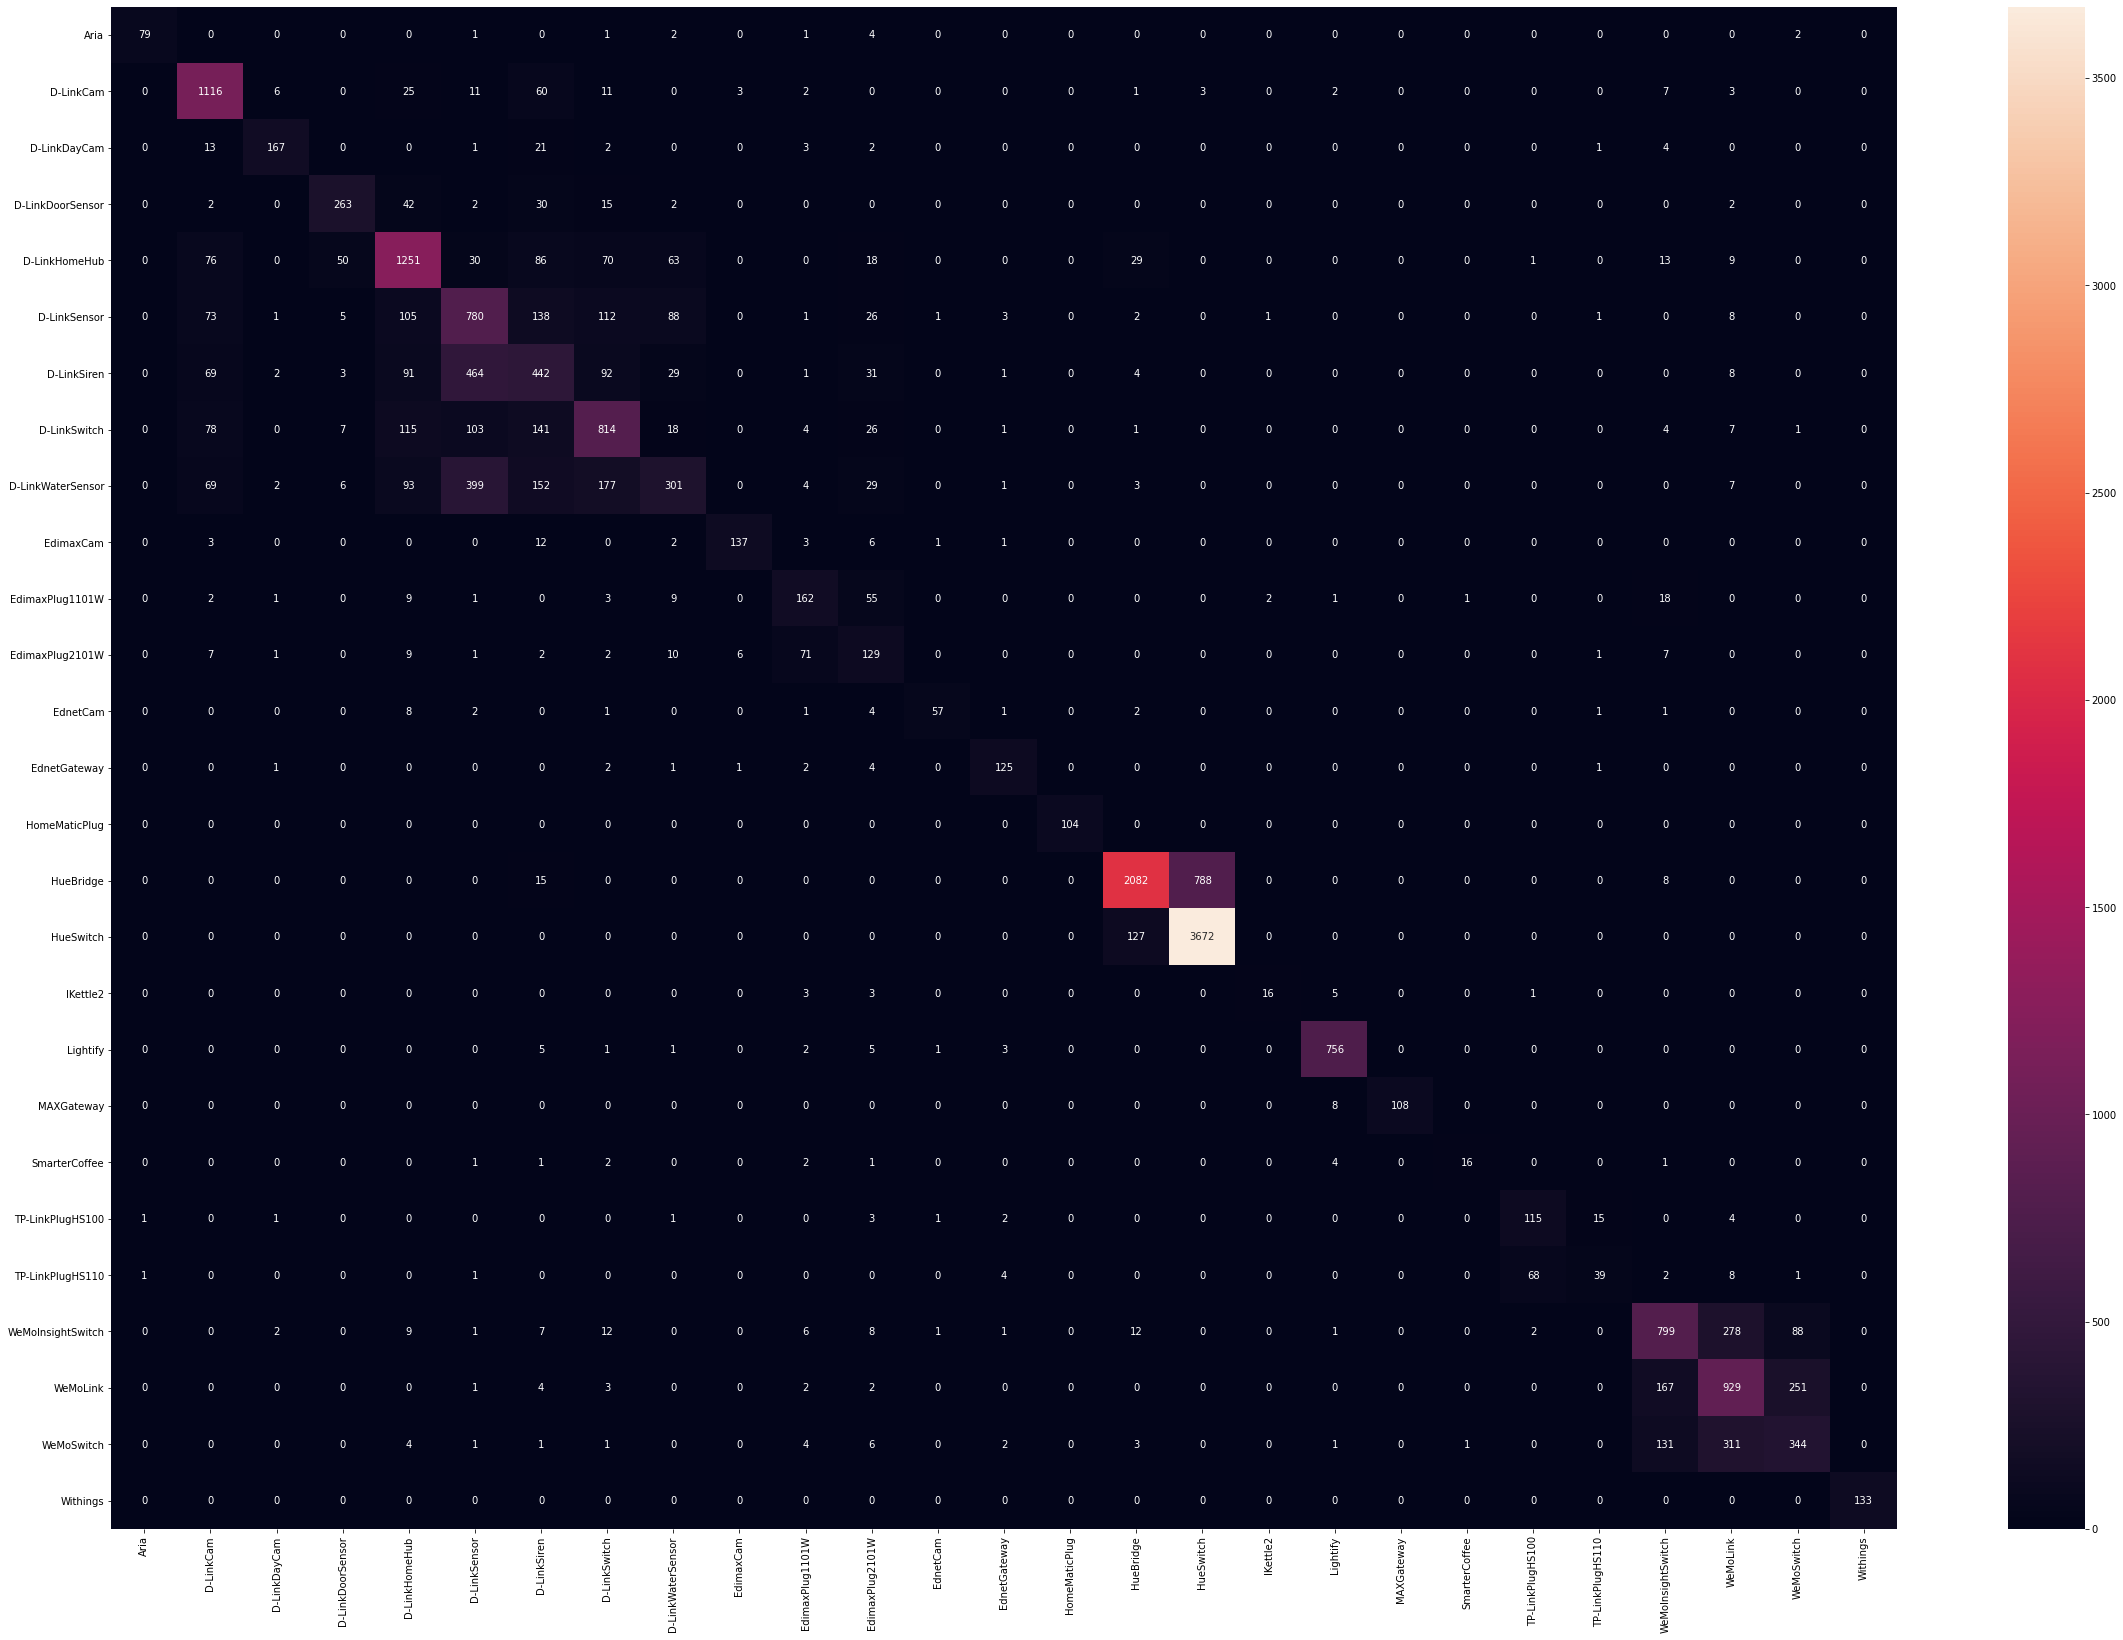





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.76   0.72    264.48  0.0     
Aalto_1         1   2   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.68   0.73    264.41  0.0     
Aalto_1         2   3   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.71   0.73    264.44  0.0     
Aalto_1         3   4   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.72   0.73    264.45  0.0     
Aalto_1         4   5   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.89   0.73    264.62  0.0     
Aalto_1         5   6   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.57   0.74    264.31  0.0     
Aalto_1         6   7   GB      0.66  0.63  0.66  0.63  0.6247   0.63  263.76   0.73    264.49  0.0     
Aalto_1         7   8   GB      0.66  0.63  0.66  0.63  0.6247   0.63  264.2    0.73    264.93  0.0     
Aalto_1         8   9   GB      0.66  0.63  0.66  0

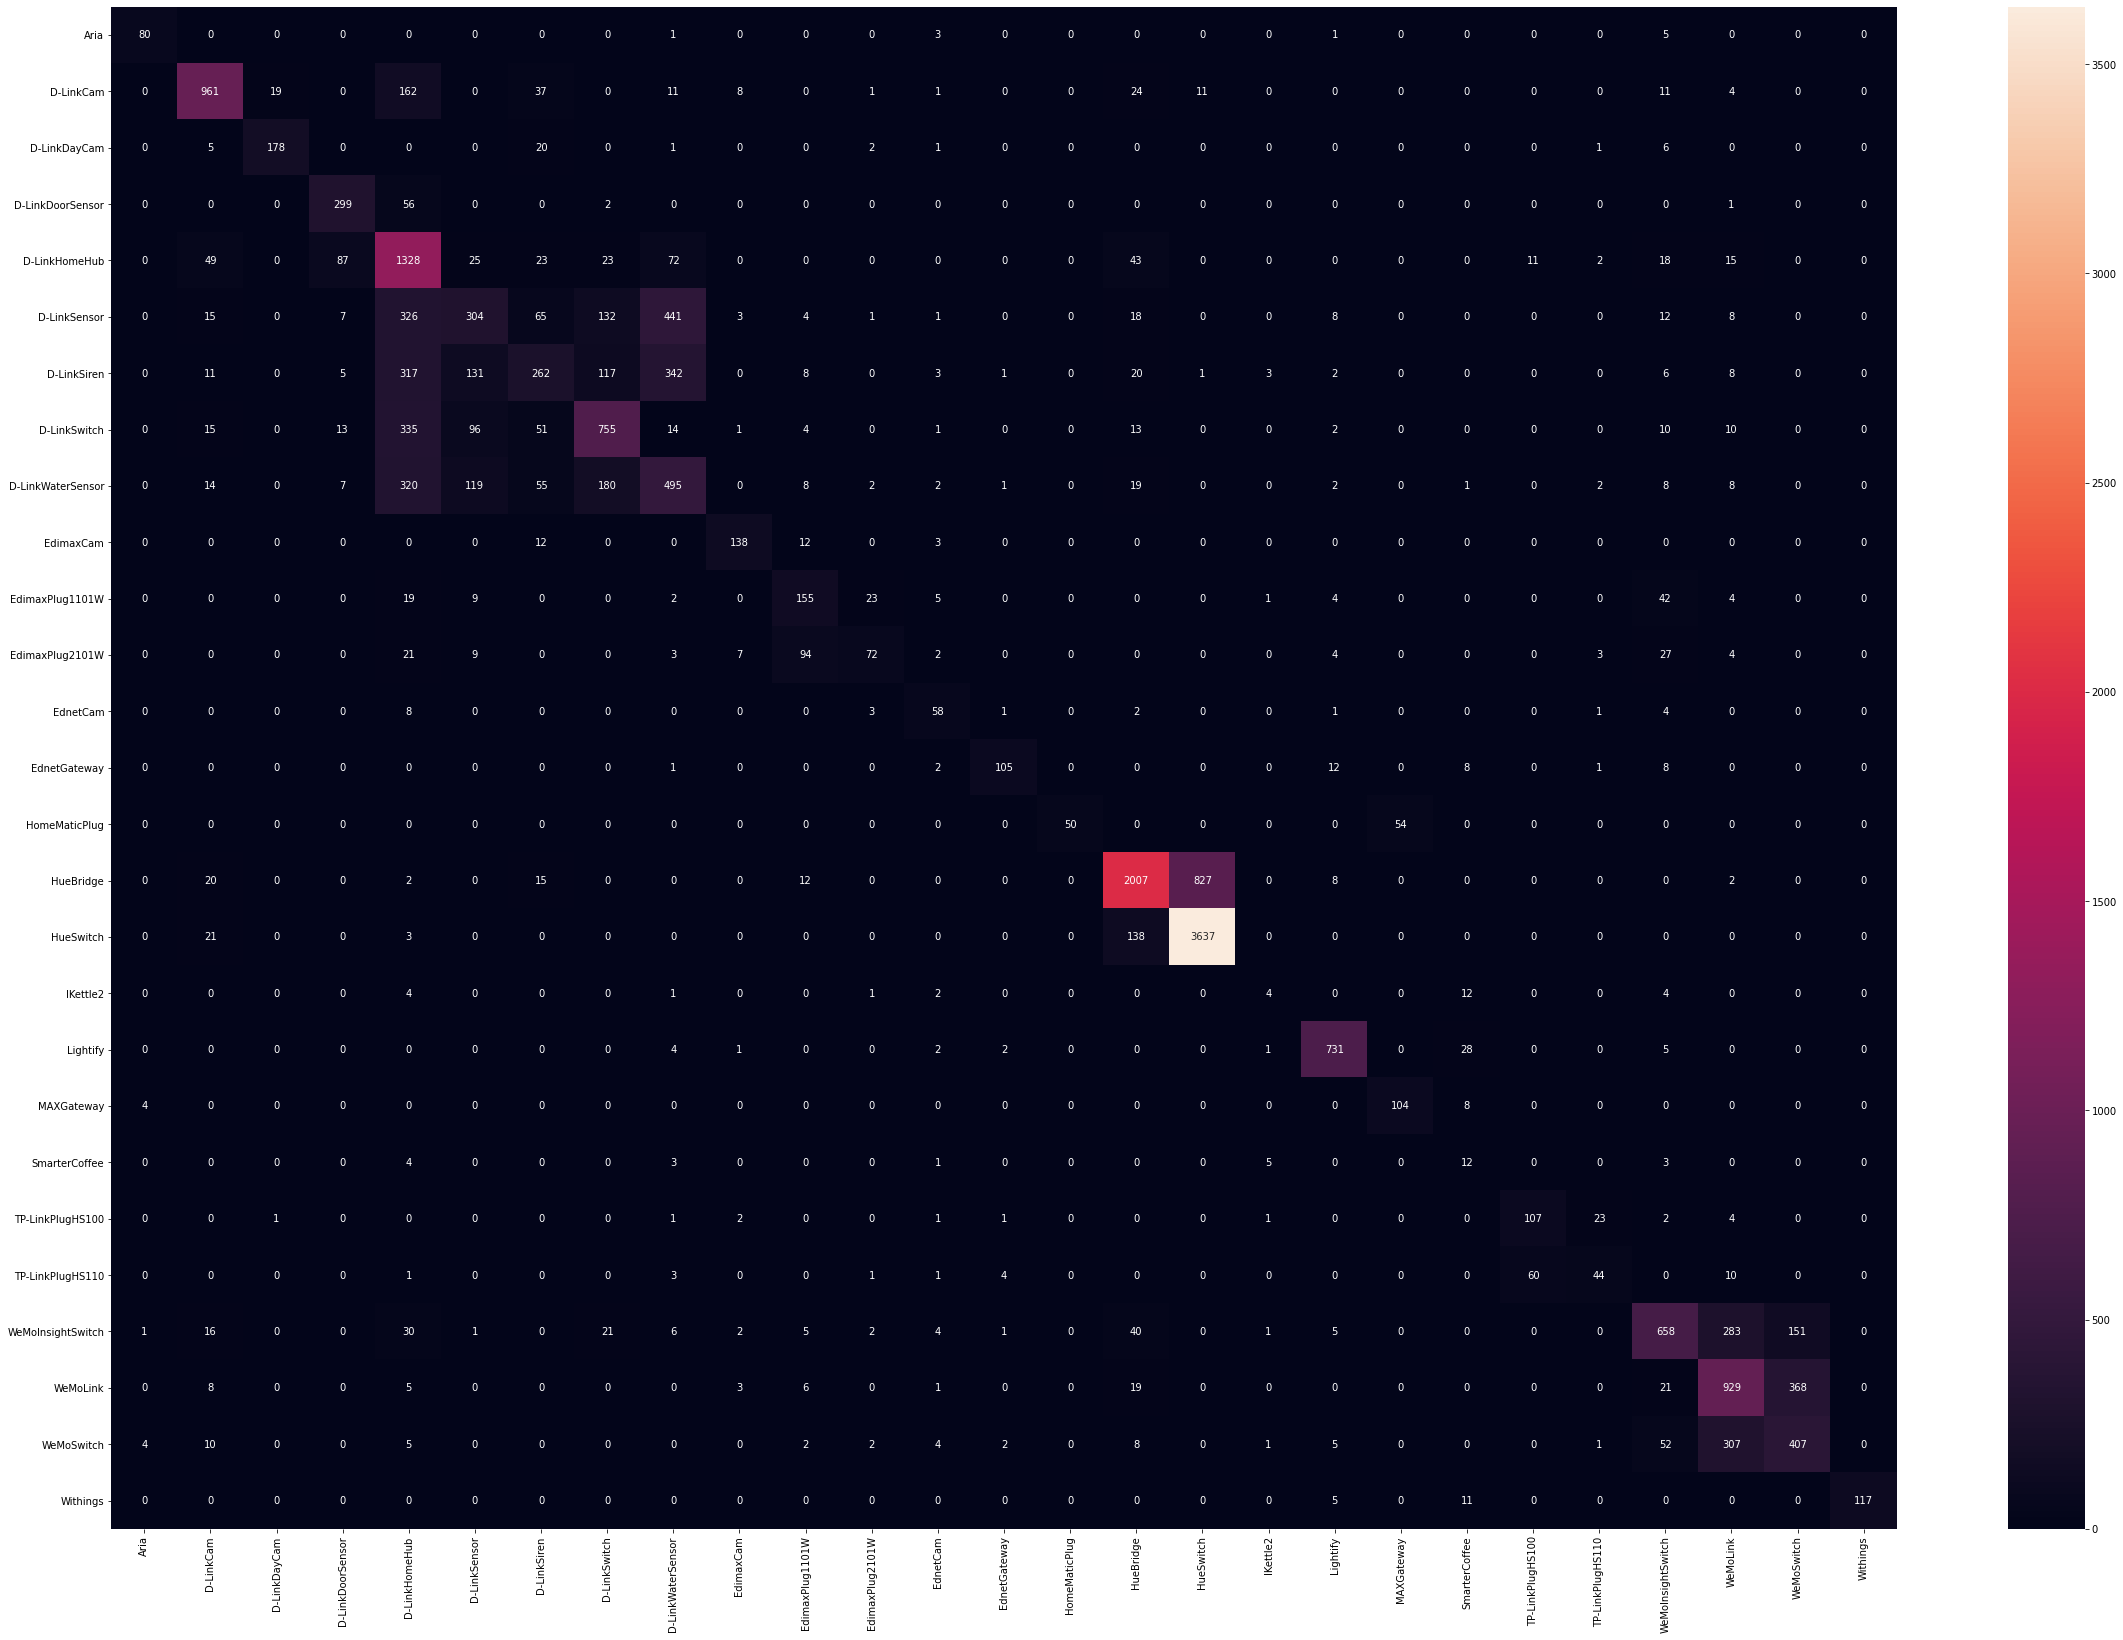

In [10]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



Aalto_train_IoTDevID

dataset="./Aalto/"
step=1


mixed=True
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


# SVM & GB

In [9]:
ml_list={"SVM":SVC(C=10,gamma=1),
         "GB":GradientBoostingClassifier(learning_rate=0.001,subsample=0.1,n_estimators=500,max_depth= 10,)}

In [ ]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



dataset="./Aalto/"
step=1


mixed=False
sayac=2
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+"100_svm_gb.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  103.6    65.4    169.01  0.0     
Aalto_1         1   2   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  102.55   65.57   168.12  0.0     
Aalto_1         2   3   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.72   65.26   166.99  0.0     
Aalto_1         3   4   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.51   64.73   166.24  0.0     
Aalto_1         4   5   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.24   64.84   166.08  0.0     
Aalto_1         5   6   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.17   64.87   166.04  0.0     
Aalto_1         6   7   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.21   64.83   166.04  0.0     
Aalto_1         7   8   SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.21   64.78   165.99  0.0     
Aalto_1         8   9   SVM     0.68  0.63  0.7   0.63 

Aalto_1         78  79  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.25   64.78   166.02  0.0     
Aalto_1         79  80  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.27   64.76   166.04  0.0     
Aalto_1         80  81  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.21   64.86   166.07  0.0     
Aalto_1         81  82  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.13   64.72   165.85  0.0     
Aalto_1         82  83  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.13   64.79   165.92  0.0     
Aalto_1         83  84  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.15   64.73   165.87  0.0     
Aalto_1         84  85  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.3    64.71   166.01  0.0     
Aalto_1         85  86  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.15   64.85   166.01  0.0     
Aalto_1         86  87  SVM     0.68  0.63  0.7   0.63  0.6493   0.65  101.4    64.73   166.13  0.0     
Aalto_1         87  88  SVM     0.68  0.63  0.7   0.63 

# GB

In [9]:
ml_list={"GB":GradientBoostingClassifier(learning_rate=0.001,subsample=0.1,n_estimators=500,max_depth= 10)}

In [10]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'



dataset="./Aalto/"
step=1


mixed=False
sayac=2
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+"100_svm_gb_GB.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto_1         0   1   GB      0.7   0.69  0.79  0.69  0.7241   0.67  923.34   8.34    931.68  0.0     
Aalto_1         1   2   GB      0.7   0.69  0.79  0.69  0.7233   0.67  917.76   8.25    926.0   0.0     
Aalto_1         2   3   GB      0.7   0.7   0.79  0.7   0.7272   0.67  915.99   8.33    924.32  0.0     
Aalto_1         3   4   GB      0.7   0.69  0.79  0.69  0.7245   0.67  916.56   8.28    924.83  0.0     
Aalto_1         4   5   GB      0.7   0.69  0.79  0.69  0.7243   0.67  917.73   8.24    925.97  0.0     
Aalto_1         5   6   GB      0.7   0.69  0.79  0.69  0.7228   0.67  917.36   8.31    925.67  0.0     
Aalto_1         6   7   GB      0.7   0.69  0.79  0.69  0.7253   0.67  915.47   8.26    923.73  0.0     
Aalto_1         7   8   GB      0.7   0.69  0.79  0.69  0.7259   0.67  918.54   8.32    926.86  0.0     
Aalto_1         8   9   GB      0.7   0.69  0.79  0.69 

Aalto_1         78  79  GB      0.7   0.69  0.79  0.69  0.7257   0.67  914.59   8.25    922.84  0.0     
Aalto_1         79  80  GB      0.7   0.69  0.79  0.69  0.7263   0.67  916.05   8.24    924.29  0.0     
Aalto_1         80  81  GB      0.7   0.69  0.79  0.69  0.7255   0.67  915.67   8.26    923.93  0.0     
Aalto_1         81  82  GB      0.7   0.69  0.79  0.69  0.724    0.67  914.74   8.27    923.02  0.0     
Aalto_1         82  83  GB      0.7   0.69  0.79  0.69  0.7248   0.67  915.87   8.27    924.14  0.0     
Aalto_1         83  84  GB      0.7   0.69  0.79  0.69  0.7235   0.67  916.95   8.41    925.36  0.0     
Aalto_1         84  85  GB      0.7   0.69  0.79  0.69  0.7236   0.67  916.0    8.24    924.23  0.0     
Aalto_1         85  86  GB      0.7   0.69  0.79  0.69  0.7248   0.67  916.21   8.28    924.48  0.0     
Aalto_1         86  87  GB      0.7   0.69  0.79  0.69  0.7244   0.67  916.2    8.37    924.57  0.0     
Aalto_1         87  88  GB      0.7   0.69  0.79  0.69 